In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model, load_model
import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
#from tensorflow.python.keras.optimizers import Adam
tf.random.set_seed(123)
from tensorflow.python.keras import backend as K
# from keras import backend as K
from tensorflow.keras.models import Sequential
session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf =  tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#sess = tf.Session(graph=tf.default_graph(), config=session_conf)
K.set_session(sess)
from skimage.transform import resize
from sklearn.metrics import jaccard_score
from keras import metrics
import csv
import segmentation_models as sm


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
path= (r'C:/Users/k v/Documents/REU/ShorelineDetection/data/')
model_path = (r'C:/Users/k v/Documents/REU/ShorelineDetection/model4/')
result_path = (r'C:/Users/k v/Documents/REU/ShorelineDetection/results/')

In [3]:
def ExtractData(path):
    SourceImg = sorted(os.listdir(path+'train_img'))
    TargetImg = sorted(os.listdir(path+'train_mask'))
   
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<2165:
            count=count+1
            img_1 = cv2.imread(path+'train_img/'+SourceImg[i])
            img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
            img_1 = cv2.resize(img_1,(500,500))
            img_1 = img_1/255.0
            X_.append(img_1)
            img_2 = cv2.imread(path+'train_mask/'+TargetImg[i])
            img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
            img_2 = cv2.resize(img_2,(500,500))
            img_2 = img_2/255.0
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [4]:
X_,y_ = ExtractData(path)

In [5]:
def AugmentData(X_, y_):
    X_2=[]
    y_2=[]
    count=0
    for i in range(len(X_)):
        if count<2165:
            count=count+1

            # Augment training images
            #img_x_1 = tf.placeholder(dtype = tf.float32, shape = X_[i])
            temp_x = []
            temp_x_1 = X_[i]
            temp_x_2 = tf.image.flip_up_down(temp_x_1)
            temp_x_3 = tf.image.flip_left_right(temp_x_1)
            temp_x_4 = tf.image.flip_up_down(temp_x_3)
            temp_x_5 = tf.image.rot90(temp_x_1)
            temp_x_6 = tf.image.rot90(temp_x_2)
            temp_x_7 = tf.image.rot90(temp_x_3)
            temp_x_8 = tf.image.rot90(temp_x_4)
            X_2.append(np.array(temp_x_1))
            X_2.append(np.array(temp_x_2))
            X_2.append(np.array(temp_x_3))
            X_2.append(np.array(temp_x_4))
            X_2.append(np.array(temp_x_5))
            X_2.append(np.array(temp_x_6))
            X_2.append(np.array(temp_x_7))
            X_2.append(np.array(temp_x_8))

            # Augment training masks
            # The augmentations here are identicial to their corresponding image counterparts.
            #img_y_1 = tf.placeholder(dtype = tf.float32, shape = y_[i])
            temp_y = []
            temp_y_1 = y_[i]
            temp_y_2 = tf.image.flip_up_down(temp_y_1)
            temp_y_3 = tf.image.flip_left_right(temp_y_1)
            temp_y_4 = tf.image.flip_up_down(temp_y_3)
            temp_y_5 = tf.image.rot90(temp_y_1)
            temp_y_6 = tf.image.rot90(temp_y_2)
            temp_y_7 = tf.image.rot90(temp_y_3)
            temp_y_8 = tf.image.rot90(temp_y_4)
            y_2.append(np.array(temp_y_1))
            y_2.append(np.array(temp_y_2))
            y_2.append(np.array(temp_y_3))
            y_2.append(np.array(temp_y_4))
            y_2.append(np.array(temp_y_5))
            y_2.append(np.array(temp_y_6))
            y_2.append(np.array(temp_y_7))
            y_2.append(np.array(temp_y_8))
    X_2 = np.array(X_2)
    y_2 = np.array(y_2)
    
    return X_2,y_2

In [6]:
X_ = X_.astype(np.float32)
y_ = y_.astype(np.float32)
# y_ = np.expand_dims(y_, axis=3)

In [7]:
X_,y_ = AugmentData(X_, y_)

In [8]:
print(X_.shape)
print(y_.shape)

(2096, 500, 500, 3)
(2096, 500, 500, 3)


In [9]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.1, random_state=42)

In [10]:
input_shape = (500, 500, 3 )
VGG16_weight = "../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

print('Model loaded.')

Model loaded.


In [11]:
output_ = VGG16.output
output_

<tf.Tensor 'block5_pool_1/Identity:0' shape=(None, 15, 15, 512) dtype=float32>

In [12]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [13]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,True
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


In [14]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [15]:
K.clear_session()
def ModelEnhancer():
    input_shape = (500, 500, 3 )
#     VGG16_weight = "../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
#     VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    VGG16=tf.keras.applications.VGG16( input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
   
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [16]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [17]:
iou_score = sm.metrics.IOUScore()
metrics = [sm.metrics.IOUScore(), 'accuracy', sm.metrics.FScore()]
Model_.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = metrics)
#Adam(lr = 1e-4)

In [18]:
checkpointer = ModelCheckpoint(model_path+'model_TL_UNET.h5', verbose=1, mode='auto', monitor='loss',save_best_only=True, save_weights_only=True)

In [19]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
results = Model_.fit(GenerateInputs(X_train,y_train), epochs=500, validation_data=(X_test,y_test), verbose=1, callbacks=[checkpointer], steps_per_epoch=2,
                     shuffle=True)
# results = Model_.fit(X_train, y_train, epochs=5, validation_data=(X_test,y_test), verbose=1, callbacks=[checkpointer], steps_per_epoch=2,
#                      shuffle=True)

  ...
    to  
  ['...']
Train for 2 steps, validate on 210 samples
Epoch 1/500
1/2 [==============>...............] - ETA: 14s - loss: 3.2471 - iou_score: 0.0176 - accuracy: 0.5490 - f1-score: 0.0342
Epoch 00001: loss improved from inf to 2.92534, saving model to C:/Users/k v/Documents/REU/ShorelineDetection/model4/model_TL_UNET.h5
2/2 [==============================] - 30s 15s/step - loss: 2.9253 - iou_score: 0.1802 - accuracy: 0.5621 - f1-score: 0.2273 - val_loss: 9.7900 - val_iou_score: 0.0553 - val_accuracy: 0.1661 - val_f1-score: 0.0536
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 2.9913 - iou_score: 0.1040 - accuracy: 0.5578 - f1-score: 0.1766
Epoch 00002: loss did not improve from 2.92534
2/2 [==============================] - 14s 7s/step - loss: 2.9507 - iou_score: 0.1384 - accuracy: 0.5608 - f1-score: 0.2228 - val_loss: 9.7887 - val_iou_score: 0.0411 - val_accuracy: 0.1668 - val_f1-score: -0.0101
Epoch 3/500
1/2 [==============>...............] - ETA: 0s

In [20]:
Model_.save(model_path+'model_TL_UNET.h5')

In [23]:
Model_.load_weights(model_path+'model_TL_UNET.h5')

In [24]:
Model_.metrics_names

['loss', 'iou_score', 'accuracy', 'f1-score']

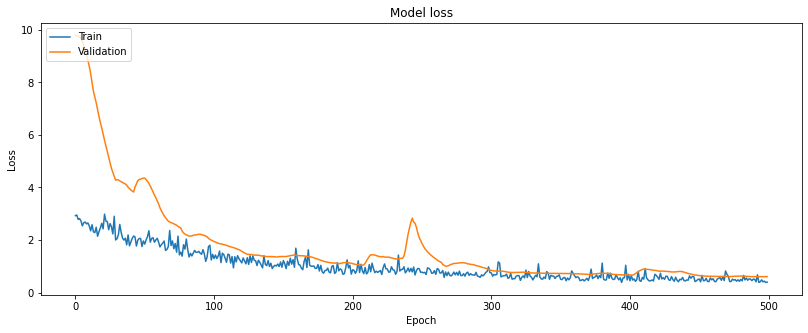

In [33]:
# Plot training & validation loss values
plt.figure(figsize=(30, 5))
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

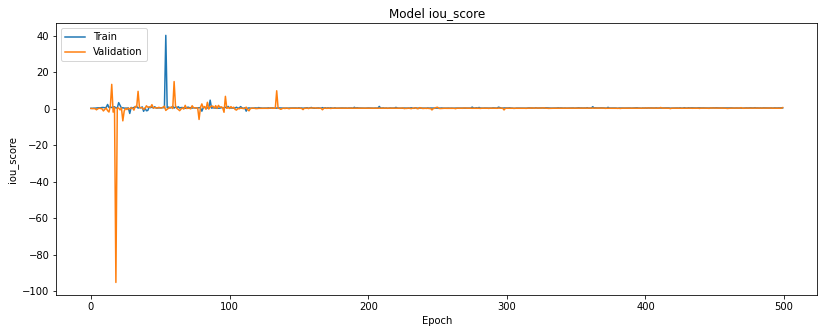

In [29]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

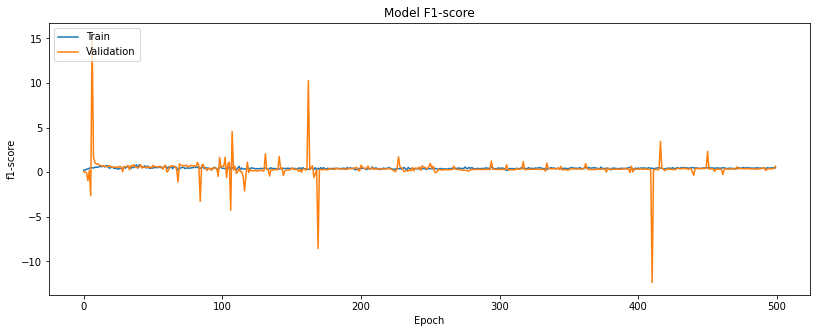

In [32]:
# Plot training & validation F1 score values
plt.figure(figsize=(30, 5))
plt.subplot(122)
plt.plot(results.history['f1-score'])
plt.plot(results.history['val_f1-score'])
plt.title('Model F1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
evaluation_score = Model_.evaluate(GenerateInputs(X_test, y_test))

  ...
    to  
  ['...']
    210/Unknown - 14s 68ms/step - loss: 0.6038 - iou_score: 0.5513 - accuracy: 0.6552 - f1-score: 0.6598

In [42]:
def ExtractData(path):
    SourceImg = sorted(os.listdir(path+'valid_img'))
    TargetImg = sorted(os.listdir(path+'valid_mask'))
   
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<2165:
            count=count+1
            img_1 = cv2.imread(path+'valid_img/'+SourceImg[i])
            img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
            img_1 = cv2.resize(img_1,(500,500))
            img_1 = img_1/255.0
            X_.append(img_1)
            img_2 = cv2.imread(path+'valid_mask/'+TargetImg[i])
            img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
            img_2 = cv2.resize(img_2,(500,500))
            img_2 = img_2/255.0
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [43]:
valid_img,valid_mask = ExtractData(path)

In [44]:
valid_img = valid_img.astype(np.float32)
valid_mask = valid_mask.astype(np.float32)

In [45]:
valid_evaluation_score = Model_.evaluate(GenerateInputs(valid_img, valid_mask))

  ...
    to  
  ['...']
     32/Unknown - 2s 71ms/step - loss: 0.5609 - iou_score: 0.3253 - accuracy: 0.6590 - f1-score: 0.3808

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


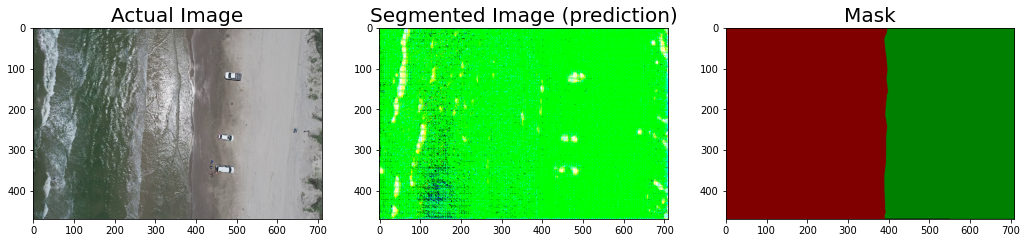

In [56]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_0 = cv2.imread(path+"valid_img/bob_700.jpg")  
image_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
image_0 = cv2.resize(image_0, (710,470))
plt.title("Actual Image",fontsize=20)
plt.imshow(image_0)
image_0 = cv2.resize(image_0,(500,500))
image_0 = image_0.reshape(1,500,500,3)
prediction_0 = Model_.predict(image_0)
pred_0 = prediction_0.reshape(500,500,3)
pred_0 = cv2.resize(pred_0,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image (prediction)",fontsize=20)
plt.imshow(pred_0, cmap='seismic')
plt.subplot(5,5,1+2)
img_g0 = cv2.imread(path+"valid_mask/bob_700.png")  
img_g0 = cv2.cvtColor(img_g0, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img_g0,(710,470), 3)
plt.title("Mask",fontsize=20)
plt.imshow(img2, cmap='gray')